BERT, Classfication layer

In [1]:
name = "bert_training_weights"

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


train_data = pd.read_csv('../datasets/data_train.csv')
test_data = pd.read_csv('../datasets/data_test.csv')
valid_data = pd.read_csv('../datasets/data_valid.csv')

all_labels = pd.concat([train_data["label"], test_data["label"], valid_data["label"]])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

LabelEncoder()

In [3]:
def extract_texts_labels(data, label_encoder):
    texts = data['data'].values
    labels = data['label'].values
    encoded_labels = label_encoder.transform(labels)
    return texts, encoded_labels

In [4]:
train_texts, train_labels = extract_texts_labels(train_data, label_encoder)
test_texts, test_labels = extract_texts_labels(test_data, label_encoder)
valid_texts, valid_labels = extract_texts_labels(valid_data, label_encoder)


In [5]:
from sklearn.utils import compute_class_weight
import numpy as np
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

In [6]:
class_weights_dict

{0: 13.252957746478874,
 1: 1.9701842546063653,
 2: 2.827403846153846,
 3: 0.5052405498281787,
 4: 0.4798368179500255}

In [7]:
label_encoder.classes_

array(['cruciate-ligament-minor', 'cruciate-ligament-urgent',
       'meniscus-minor', 'meniscus-urgent', 'other-minor'], dtype=object)

In [5]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-german-cased')

# Tokenize the data
train_encodings = tokenizer(train_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
test_encodings = tokenizer(test_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
valid_encodings = tokenizer(valid_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)

In [6]:
import tensorflow as tf

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

train_dataset = create_dataset(train_encodings, train_labels)
test_dataset = create_dataset(test_encodings, test_labels)
valid_dataset = create_dataset(valid_encodings, valid_labels)

2024-07-29 10:01:20.095158: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-29 10:01:20.095176: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-29 10:01:20.095180: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-29 10:01:20.095193: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-29 10:01:20.095203: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
from transformers import TFBertForSequenceClassification

# Load the BERT model for sequence classification with the number of output labels
model = TFBertForSequenceClassification.from_pretrained('google-bert/bert-base-german-cased', num_labels=len(label_encoder.classes_))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[ "accuracy" ]
)


In [10]:
# Train the model with early stopping callback
model.fit(train_dataset.shuffle(1000).batch(64),
          validation_data=valid_dataset.batch(64),
          epochs=3,
          class_weight=class_weights_dict
          )


Epoch 1/3
368/368 [==============================] - 1894s 5s/step - loss: 1.1978 - accuracy: 0.4141 - val_loss: 1.3970 - val_accuracy: 0.3957
Epoch 2/3
368/368 [==============================] - 1905s 5s/step - loss: 1.0057 - accuracy: 0.4586 - val_loss: 1.5079 - val_accuracy: 0.3697
Epoch 3/3
368/368 [==============================] - 2223s 6s/step - loss: 0.8763 - accuracy: 0.5041 - val_loss: 1.3897 - val_accuracy: 0.4271


In [11]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset.batch(32))
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

246/246 [==============================] - 208s 842ms/step - loss: 1.3963 - accuracy: 0.4342
Loss: 1.3963297605514526
Accuracy: 0.4342004656791687


In [12]:
model.save_pretrained(name)
tokenizer.save_pretrained(name + "_tokenizer")

('bert_classify_tokenizer/tokenizer_config.json',
 'bert_classify_tokenizer/special_tokens_map.json',
 'bert_classify_tokenizer/vocab.txt',
 'bert_classify_tokenizer/added_tokens.json')

In [13]:
import numpy as np
predictions = model.predict(test_dataset.batch(32))
predicted_labels = np.argmax(predictions.logits, axis=-1)

# Decode class labels to original labels
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# True labels from the test set
true_labels = label_encoder.inverse_transform(test_labels)

# Create a DataFrame to compare
comparison_df = pd.DataFrame({'Text': test_texts, 'True Label': true_labels, 'Predicted Label': decoded_predictions})

246/246 [==============================] - 170s 683ms/step


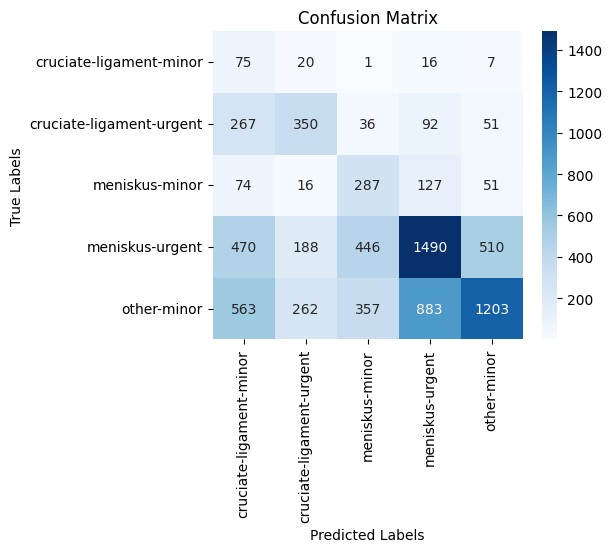

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, decoded_predictions, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

 cruciate-ligament-minor       0.05      0.63      0.10       119
cruciate-ligament-urgent       0.42      0.44      0.43       796
          meniskus-minor       0.25      0.52      0.34       555
         meniskus-urgent       0.57      0.48      0.52      3104
             other-minor       0.66      0.37      0.47      3268

                accuracy                           0.43      7842
               macro avg       0.39      0.49      0.37      7842
            weighted avg       0.56      0.43      0.47      7842



In [16]:
from sklearn.metrics import classification_report
report = classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_, output_dict=True)

In [18]:
df = pd.DataFrame(report).transpose()
df.to_csv(name + "_report.csv")